# Assignment #3 - Reinforcement Learning

### <font color="red"> DUE: Mar 19 (Monday) 11:00 pm </font>  

<font color="blue"> Venkata Sai Santosh Ravi Teja Kancharla </font>

# I. Overview

In this assignment, we have to simulate two problems: Maze and Black jack. We then need to develop reinforcement models for these problems using TD learning methods to automate the process and get optimal rewards from it. The main objective of this assignment is to provide hands-on-experiance in using Reinforcement learining techniques. We first understand both the problems, know the basic requirements, like states, rewards, actions etc and see how we can use reinforcement learning to solve them. Another important aspect is to choose proper TD learning method, SARSA or Q learning, based on our problem nature. 

# II. Problems 

## A. Maze Problem (Practice)

The maze problem has a 2-dimensional maze which has a start point and a goal point, with some obstacles in between. The goal of the player is to reach the goal from start point in an optimal path without encountering an obstacle. The main objective is finding an optimal path rather than just a path, because there is penalty for each step taken in the maze, thus, less number of steps is required for maximum reward. A reward is given to the player upon reaching the goal. Getting in contact with an obstacle will result in negative reward and also makes the player out of the maze and he has to start again. 

In [6]:
import collections
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Sample Grid Environment File

To simulate the maze problem, we take a simple text file with three characters, 'O', 'H', and 'G'.
- 'O': open space
- 'H': Wall or obstacles
- 'G': Goal location 

In [5]:
f = open("grid.txt","r")
print(f.read())

OOOHOOOOO
OOOHOOHOO
OOOOOOHOO
OOOOHHHOO
OOHOOOOOH
OOHOOOGOO
OOOOOOOOO


### GridWorld Class

We define a GridWorld Class to simulate the maze problem. The GridWorld class takes in a 2D array which we described above as a maze problem. The states of the player is the (x,y) which gives the position in the grid map. The actiions here are considered as 0,1,2,3 for left, right, up, down respectively. Also, we consider the rewards as -1 for every step made, -5 if the player hits an obstacle and +30 upon reaching the goal. It has the following important functions:
- \__init\__(): initialzes the object with the map, size of the map and the goal position which is predefined in the map.
- get_cur_state(): returns the current position of the player.
- print_map(): Prints the loaded map.
- check_state(): checks the current state of the player, whether it is valid state or not(out of the maze or not).
- init(): initializes the start state
- next(): An action is provided as input. Porgresses the player to the next state based on his action.
- is_goal(): Checks whether the player reached the goal or not.

In [6]:
# maze example

class GridWorld:
    """ Grid World environment
            there are four actions (left, right, up, and down) to move an agent
            In a grid, if it reaches a goal, it get 30 points of reward.
            If it falls in a hole or moves out of the grid world, it gets -5.
            Each step costs -1 point. 

        to test GridWorld, run the following sample codes:

            env = GridWorld('grid.txt')

            env.print_map()
            print [2,3], env.check_state([2,3])
            print [0,0], env.check_state([0,0])
            print [3,4], env.check_state([3,4])
            print [10,3], env.check_state([10,3])

            env.init([0,0])
            print env.next(1)  # right
            print env.next(3)  # down
            print env.next(0)  # left
            print env.next(2)  # up
            print env.next(2)  # up

        Parameters
        ==========
        _map        ndarray
                    string array read from a file input
        _size       1d array
                    the size of _map in ndarray
        goal_pos    tuple
                    the index for the goal location
        _actions    list
                    list of actions for 4 actions
        _s          1d array
                    current state
    """
    def __init__(self, fn):
        # read a map from a file
        self._map = self.read_map(fn)
        self._size = np.asarray(self._map.shape)
        self.goal_pos = np.where(self._map == 'G')

        # definition of actions (left, right, up, and down repectively)
        self._actions = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self._s = None

    def get_cur_state(self):
        return self._s

    def get_size(self):
        return self._size

    def read_map(self, fn):
        grid = []
        with open(fn) as f:
            for line in f:
                grid.append(list(line.strip()))
        return np.asarray(grid)

    def print_map(self):
        print( self._map )

    def check_state(self, s):
        if isinstance(s, collections.Iterable) and len(s) == 2:
            if s[0] < 0 or s[1] < 0 or\
               s[0] >= self._size[0] or s[1] >= self._size[1]:
                return 'N'
            return self._map[tuple(s)].upper()
        else:
            return 'F'  # wrong input

    def init(self, state=None):
        if state is None:
            s = [0, 0]
        else:
            s = state

        if self.check_state(s) == 'O':
            self._s = np.asarray(state)
        else:
            raise ValueError("Invalid state for init")

    def next(self, a):
        s1 = self._s + self._actions[a]
        # state transition
        curr = self.check_state(s1)
        
        if curr == 'H' or curr == 'N':
            return -5
        elif curr == 'F':
            warnings.warn("invalid state " + str(s1))
            return -5
        elif curr == 'G':
            self._s = s1
            return 30
        else:
            self._s = s1
            return -1
        
    def is_goal(self):
        return self.check_state(self._s) == 'G'
            
    def get_actions(self):
        return self._actions

Lest test the working of the class  

In [8]:
env = GridWorld("grid.txt")
env.print_map()

[['O' 'O' 'O' 'H' 'O' 'O' 'O' 'O' 'O']
 ['O' 'O' 'O' 'H' 'O' 'O' 'H' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'H' 'O' 'O']
 ['O' 'O' 'O' 'O' 'H' 'H' 'H' 'O' 'O']
 ['O' 'O' 'H' 'O' 'O' 'O' 'O' 'O' 'H']
 ['O' 'O' 'H' 'O' 'O' 'O' 'G' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']]


In [9]:
# top-left to (0,0)
def coord_convert(s, sz):
    return [s[1], sz[0]-s[0]-1]

We will look how the next() function moves the player based on provided actions. 

In [10]:
print([2,3]), env.check_state([2,3])
print([0,0]), env.check_state([0,0])
print([3,4]), env.check_state([3,4])
print([10,3]), env.check_state([10,3])

env.init([0,0])
print(env.next(1))  # right
print(env.next(3))  # down
print(env.next(0))  # left
print(env.next(2)) # up
print(env.next(2))  # up

[2, 3]
[0, 0]
[3, 4]
[10, 3]
-1
-1
-1
-1
-5


## B. Blackjack-V0

![](https://upload.wikimedia.org/wikipedia/commons/a/a2/Blackjack_game_1.JPG)

Now, we play Blackjack! 
https://gym.openai.com/envs/Blackjack-v0/


Blackjack is a card game where the goal is to obtain cards that sum to as near as possible to 21 without going over.  They're playing against a fixed dealer. Face cards (Jack, Queen, King) have point value 10. Aces can either count as 11 or 1, and it's called 'usable' at 11. This game is placed with an infinite deck (or with replacement). The game starts with each (player and dealer) having one face up and one face down card.

The player can request additional cards (hit=1) until they decide to stop (stick=0) or exceed 21 (bust). After the player sticks, the dealer reveals their facedown card, and draws until their sum is 17 or greater.  If the dealer goes bust the player wins. If neither player nor dealer busts, the outcome (win, lose, draw) is decided by whose sum is closer to 21.  The reward for winning is +1, drawing is 0, and losing is -1. The observation of a 3-tuple of: the players current sum, the dealer's one showing card (1-10 where 1 is ace), and whether or not the player holds a usable ace (0 or 1).

Here, we have a class BlackJacjEnv which simulates the black jack game as described above. There are some helping functions:

- cmp(): to compare the value of hands of player and dealer.
- draw_card(): returns a random value of cards.
- draw_hand(): returns an array with card values. Used for initial distribution of cards.
- score(): returns the sum of values of cards with a player or dealer.
- bust(): tells whether the player or delear is busted or not.
- is_natural(): tells whether the hand is natural black jack or not

The class has the following functions:
- \__init()\__: initializes the object with the action space and the observation space. Here action space is the possible actions in the black jack game. 
- step(): This function implements the action requested and changes the state of the game. If the player decides to stick, it draws cards for the dealer until he reaches a mark greater than 17.
- get_obs(): Returns the observation, which has the value of player hand, delaer hand and usable ace.
- reset(): This resets the game by issuing new card values to the dealer and player.

In [7]:
import gym

from gym import spaces

from gym.utils import seeding



def cmp(a, b):

    return float(a > b) - float(a < b)



# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10

deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]





def draw_card(np_random):

    return int(np_random.choice(deck))





def draw_hand(np_random):

    return [draw_card(np_random), draw_card(np_random)]





def usable_ace(hand):  # Does this hand have a usable ace?

    return 1 in hand and sum(hand) + 10 <= 21





def sum_hand(hand):  # Return current hand total

    if usable_ace(hand):

        return sum(hand) + 10

    return sum(hand)





def is_bust(hand):  # Is this hand a bust?

    return sum_hand(hand) > 21





def score(hand):  # What is the score of this hand (0 if bust)

    return 0 if is_bust(hand) else sum_hand(hand)





def is_natural(hand):  # Is this hand a natural blackjack?

    return sorted(hand) == [1, 10]





class BlackjackEnv(gym.Env):

    """Simple blackjack environment

    This environment corresponds to the version of the blackjack problem

    described in Example 5.1 in Reinforcement Learning: An Introduction

    by Sutton and Barto (1998).

    http://incompleteideas.net/sutton/book/the-book.html

    """

    def __init__(self, natural=False):

        self.action_space = spaces.Discrete(2)

        self.observation_space = spaces.Tuple((

            spaces.Discrete(32),

            spaces.Discrete(11),

            spaces.Discrete(2)))

        self.seed()



        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules

        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/

        self.natural = natural

        # Start the first game

        self.reset()



    def seed(self, seed=None):

        self.np_random, seed = seeding.np_random(seed)

        return [seed]



    def step(self, action):

        assert self.action_space.contains(action)

        if action:  # hit: add a card to players hand and return

            self.player.append(draw_card(self.np_random))

            if is_bust(self.player):

                done = True

                reward = -1

            else:

                done = False

                reward = 0

        else:  # stick: play out the dealers hand, and score

            done = True

            while sum_hand(self.dealer) < 17:

                self.dealer.append(draw_card(self.np_random))

            reward = cmp(score(self.player), score(self.dealer))

            if self.natural and is_natural(self.player) and reward == 1:

                reward = 1.5

        return self._get_obs(), reward, done, {}



    def _get_obs(self):

        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))



    def reset(self):

        self.dealer = draw_hand(self.np_random)

        self.player = draw_hand(self.np_random)

        return self._get_obs()

Let us create an object for the class and test some of it's functions.

In [66]:
env2 = BlackjackEnv()
a,b,c,r = env2.step(1)
print(a,b,c)
a,b,c,r = env2.step(1)
print(a,b,c)

(25, 1, False) -1 True
(29, 1, False) -1 True


# III. Methods

- Decide your TD learning approach: SARSA or Q-learning? 
- Describe your approach and the reason why you select it.
- Finish epsilon_greedy function and other TODOs. Explain it.
- Explain your codes.

## RLAgent for Maze

We will now write a Reinforcement learning agent for the Maze problem. Here we have to consider the following aspects based on our understanding of the maze problem:
- States: The positions possible for the player to be in, in the maze grid in the form of (x,y), where x represents the row and y represents the column.
- Actions: 0,1,2,3 which represents left, right, up, down respectively.
- Rewards: +1, -5, +30 for every step, obstacle and goal respectively

**We can observe that the reward for hitting an obstacle is very much negative and also makes the player out of the maze. As the penalty is very much high, we need to avoid them at any chance. Q-learning will tend to trigger that high negative reward while exploring, while SARSA will tend to avoid a dangerous optimal path and only slowly learn to use it when the exploration parameters are reduced. Hence it will be efficient to use SARSA in this case.** 

SARSA stands for State-Action-Reward-State-Action. In SARSA, the agent starts in state 1, performs action 1, and gets a reward. Now, it’s in state 2 and performs action 2 and gets the reward before it goes back and updates the value of action 1 performed in state 1. In contrast, in Q-learning the agent starts in state 1, performs action 1 and gets a reward (reward 1), and then looks and sees what the maximum possible reward for an action is in state 2, and uses that to update the action value of performing action 1 in state 1. So the difference is in the way the future reward is found. 

The Q table in SARSA is updated as :

$$
    Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha ( R_{t+1} + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t)) 
$$



We define a class called RLAgent for our maze problem. We initialze it with a environment object of the Grid world, thus providing the details about states, rewards and actions. We also initialize a Q table which we use later to generate a policy for the problem. 

We have 2 helping methods, greedy and epsilon_greedy which we use to get the index of maximum value of Q for getting the action based on the Q table. We have the function called train(), which implements the SARSA learning method to generate the Q table. We loop the interation of finding a path upto a maximum number specified by the user. We also have a limit to the number iterations to be made before finding a path. If after the limit of iterations we couldn't find the path, we can return.

We keep track of the rewards, steps and also the path. We then use this Q table in our test(), to generate a policy. Using this policy we iterate the maze problem from a specified start position and see whether the policy is making the player reach the goal. We aslo record our rewards and plot them to analyze the performance of the RLAgent.

In [8]:
class RLAgent: 
    """
        Reinforcement Learning Agent Model for training/testing
        with Tabular function approximation
        
    """
    
    def __init__(self, env):
        self.env = env
        self.size = env.get_size()
        self.n_a = len(env.get_actions())
        # self.Q table including the surrounding border
        self.Q = np.zeros((self.size[0], self.size[1], self.n_a))
    
    def greedy(self, s):
        return np.argmax(self.Q[s[0],s[1]])
    
    def epsilon_greed(self, epsilon, s):
        # TODO: Finish this function
        if np.random.rand() < epsilon:
            return np.random.randint(self.n_a)
        else:
            return self.greedy(s)
    
    def train(self, start, **params):
        
        # parameters
        gamma = params.pop('gamma', 0.99)
        alpha = params.pop('alpha', 0.1)
        epsilon= params.pop('epsilon', 0.1)
        maxiter= params.pop('maxiter', 1000) 
        maxstep= params.pop('maxstep', 1000)
        
        # init self.Q matrix
        self.Q[...] = 0
        self.Q[self.env._map == 'H'] = -np.inf
        
        # online train
        # rewards and step trace
        rtrace = []
        steps = []
        for j in range(maxiter):

            env.init(start)
            s = env.get_cur_state()
            # selection an action
            a = self.epsilon_greed(epsilon, s)

            rewards = []
            trace = np.array(coord_convert(s, self.size))
            # run simulation for max number of steps 
            for step in range(maxstep):
                # move
                r = env.next(a)
                s1 = env.get_cur_state()
                a1 = self.epsilon_greed(epsilon, s1)

                rewards.append(r)
                trace = np.vstack((trace, coord_convert(s1, self.size)))

                # TODO: FINISH SARSA/Q-learning Rule here
                # update self.Q table 
                self.Q[s[0],s[1], a] += alpha * (r + gamma * self.Q[s1[0],s1[1], a1] - self.Q[s[0],s[1],a])
                
                if env.is_goal(): # reached the goal
                    # TODO: Why is this zero? Describe this in your code explanation.
                    self.Q[s1[0], s1[1], a1] = 0
                    break

                s = s1
                a = a1

            rtrace.append(np.sum(rewards))
            steps.append(step+1)
        return rtrace, steps, trace # last trace of trajectory

    def test(self, start, maxstep=1000):
        # TODO: Add your test routine that exmines learned policy
        #      Using the learned policy, generate the trajectory of
        gamma = 0.99
        alpha = 0.1
        rewards =0
        pi = np.argmax(self.Q, axis=2)
        #for e in range(50):
        env.init(start)
        s = env.get_cur_state()
        trace = np.array(coord_convert(s, self.size))
        for step in range(maxstep):
            a = pi[s[0],s[1]]
            r1 = env.next(a)
            s1 = env.get_cur_state()
            trace = np.vstack((trace, coord_convert(s1, self.size)))
            s = s1
            rewards += r1
            if env.is_goal():
                break
        return trace,pi, rewards           

**#TODO**: Here we can observe that, once the position reaches to goal, we are updating the Q - table values at that state to be zero(0). In SARSA, the agent actually makes a move before recording the value in the Q table for the previous state. So, the zero is to indicate the final state is reached and no further step can give any rewards.

## RLAgent for Gym (Blackjack-V0)

We will now write a Reinforcement learning agent for the Black Jack. Here we have to consider the following aspects based on our understanding of the Balck jack problem:
States: A state in the black jack game is represented by an observation which is defined in the class.
Actions: hit, stick or bust
Rewards: +1, +1.5, -1 for every win, natural_win and loss respectively

Here, unlike the previous problem, the penalty for loosing is not that high and we can consider using Q learning in this case. Q-learning can be used to find an optimal action-selection policy for any given (finite) Markov decision process. It works by learning an action-value function that ultimately gives the expected utility of taking a given action in a given state and following the optimal policy thereafter.

$$
    Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha ( R_{t+1} + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t)) 
$$

We will create an Agent class called RLAgentB, which will learn and test the black jack problem.

Unlike our previous problem, the states cannot be predicted before hand. Hence we have a dictionary for the Q table, which has values stored for each observation encountered. The observation space is not defined initially, and when we encounter a new observation, we record it into our Q table. Therefore, we have a additional function called createQ() which creates an entry in the Q table when a new observation is made. This class also has the epsilon_greedy() and greedy() functions similar to RLAgent.

The choose_action() function chooses an action from the action space and returns it. The train() updates the Q table based on the Q learning method. Here, the train method is called with number of rounds and number of samples. The number rounds represents the rounds played by a player. The number of samples is the number of times these rounds are repeated. We record the total reward the player gets during each sample and then record the average reward he gets after playing for specified number of rounds. 

The test() function, takes a observation as input, and based on the Q table recorded, it decides how the play proceeds from that point.

The main function here is the test2() function which records the total rewards of a player after playing for specified number of times based on the Q table generated in the train().


In [9]:
class RLAgentB: 
    """
        Reinforcement Learning Agent Model for training/testing
        with Tabular function approximation
        
    """
    
    def __init__(self, env, epsilon, alpha, gamma):
        self.env = env
        self.valid_actions = list(range(self.env.action_space.n))
        self.n_a = len(self.valid_actions)
        # Set parameters of the learning agent
        self.Q = dict()          # Q-table which will be a dictionary of tuples
        self.epsilon = epsilon   # Random exploration factor
        self.alpha = alpha       # Learning factor
        self.gamma = gamma     
        
    def createQ(self, observation):
        if observation not in self.Q:
            self.Q[observation] = dict((action, 0.0) for action in self.valid_actions)

    def get_maxQ(self, observation):
        self.createQ(observation)
        return max(self.Q[observation].values())

    
    def greedy(self, observation):
        maxQ = self.get_maxQ(observation)
        return np.random.choice([k for k in self.Q[observation].keys()
                       if self.Q[observation][k] == maxQ])
    
    def epsilon_greedy(self, observation):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.valid_actions)
        else:
            return self.greedy(observation)

    def choose_action(self, observation):
        self.createQ(observation)
        action = self.epsilon_greedy(observation)
        return action


    def train(self, num_rounds, num_samples):
        
        #num_rounds = 1000 # Payout calculated over num_rounds
        #num_samples = 1000 # num_rounds simulated over num_samples
        observation = self.env.__init__()
        average_reward = []
        #rtrace = []
        #steps = []
        
        for sample in range(num_samples):
            round = 1
            total_reward = 0
            while round <= num_rounds:
                # play
                action = self.choose_action(observation)
                next_observation, reward, is_done, _ = self.env.step(action)
                self.Q[observation][action] += self.alpha * (reward
                                                     + (self.gamma * self.get_maxQ(next_observation))
                                                     - self.Q[observation][action])
                total_reward += reward
                observation = next_observation
                if is_done:
                    observation = self.env.reset() # Environment deals new cards to player and dealer
                    round += 1
            average_reward.append(total_reward)
                    
            #rtrace.append(np.sum(rewards))
        return average_reward
    
    def test(self, observation, num_rounds):
        #is_done = False
        total_reward = 0
        round = 1
        obs = observation
        while round<= num_rounds:
            maxQ = self.get_maxQ(observation)
            action= np.random.choice([k for k in self.Q[observation].keys()
                                      if self.Q[observation][k] == maxQ])
            next_observation, reward, is_done, _ = self.env.step(action)
            observation = next_observation
            total_reward+= reward
            if is_done:
                observation = obs # Environment deals new cards to player and dealer
                round += 1
        return total_reward
 
    def test2(self, num_rounds):
        #num_rounds = 1000
        observation = self.env.__init__()
        total_reward = 0
        win = 0
        round = 1
        while round <= num_rounds:
            maxQ = self.get_maxQ(observation)
            action= np.random.choice([k for k in self.Q[observation].keys()
                                      if self.Q[observation][k] == maxQ])
            next_observation, reward, is_done, _ = self.env.step(action)
            total_reward += reward
            if reward >= 1:
                win += 1
            observation = next_observation
            if is_done:
                observation = self.env.reset() # Environment deals new cards to player and dealer
                round += 1
        return total_reward, win

# IV - Results

- Describe the choice of your parameters for $\gamma$, $\alpha$, and $\epsilon$. 
  - Run experiments to find good parameters
  - Show the experimental outputs to show the process of your selection
- Visualize the results and explain outputs (even from mine.)
  - Run the codes and tell me what you observe
  - Add more visualizations to enrich your explanation.

### Utility functions for Plotting

Here we define some utility functions for plotting our results for Maze problem. We plot the rewards, steps, a contour plot for the maze and plot traces denoting the path to the goal - in the plot_train() function. This is used for the train data. For the test data, we plot the path form the start to goal using the plot_trace() function. 

In [12]:
### Plotting tools 

def plot_trace(agent, start, trace, title="test trajectory"):
    plt.plot(trace[:, 0], trace[:, 1], "ko-")
    plt.text(env.goal_pos[1], agent.size[0]-env.goal_pos[0]-1, 'G')
    plt.text(start[1], agent.size[0]-start[0]-1, 'S')
    plt.xlim([0, agent.size[1]])
    plt.ylim([0, agent.size[0]])
    

def plot_train(agent, rtrace, steps, trace, start):

    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(221)
    # TODO: plot rewards 
    plt.plot(rtrace)
    plt.ylabel("sum of rewards")

    ax1 = fig.add_subplot(222)
    # TODO: plot steps
    plt.plot(steps)
    plt.ylabel("# steps")

    # contour plot for agent.Q
    ax2 = fig.add_subplot(223)
    xs = range(agent.size[1])
    ys = range(agent.size[0])
    maxQ = np.max(agent.Q, axis=2)
    h_b = (maxQ==-np.inf)
    maxQ[h_b] = 0
    maxQ[h_b] = np.min(maxQ) - 100
    cs = plt.contourf(xs, ys[::-1], maxQ)
    plt.colorbar(cs)
    plt.text(env.goal_pos[1], agent.size[0]-env.goal_pos[0]-1, 'G')
    plt.text(start[1], agent.size[0]-start[0]-1, 'S')
    plt.ylabel("max agent.Q")

    # plot traces
    ax3 = fig.add_subplot(224)
    plot_trace(agent, start, trace, "trace of the last episode")

    plt.plot()

In [4]:
## plotting function for BlackJack Agent

def plotBlackJack(ar):  
    plt.plot(ar)           
    plt.xlabel('num_samples')
    plt.ylabel('reward after 1000 rounds')
    plt.show()

### Training and Testing with GridWorld

We train the grid world with different parameters and try to find out some good parameters.

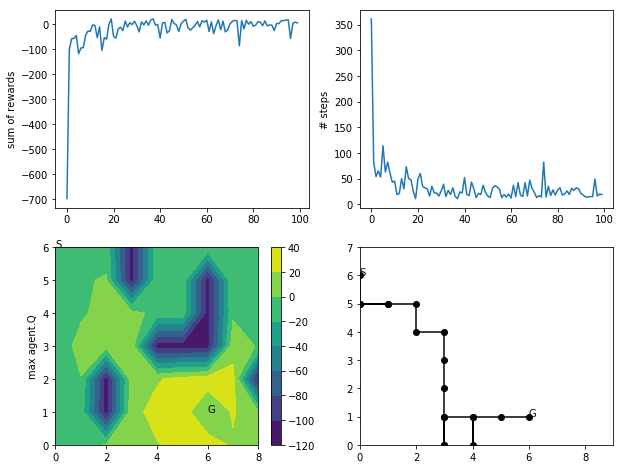

In [30]:
agent = RLAgent(env)
start = [0,0]
rtrace, steps, trace = agent.train(start, 
                                   gamma=0.99, 
                                   alpha=0.5, 
                                   epsilon=0.5, 
                                   maxiter=100, 
                                   maxstep=1000)
plot_train(agent, rtrace, steps, trace, start)

Initially, we considered 0.5 for alpha and epsilon and 0.99 for gamma. The results are not that good, as the number steps taken near to 100th interation are very high. We need an optimal path.

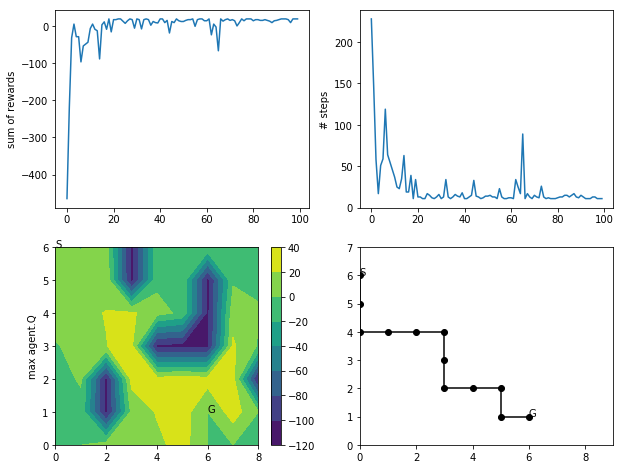

In [31]:
agent = RLAgent(env)
start = [0,0]
rtrace, steps, trace = agent.train(start, 
                                   gamma=0.99, 
                                   alpha=0.7, 
                                   epsilon=0.1, 
                                   maxiter=100, 
                                   maxstep=1000)
plot_train(agent, rtrace, steps, trace, start)

We decreased the value of epsilon and gave 0.7 to alpha. Here, the optimal path is looked to be achieved near the 100th iteration, but still there are some peaks near the half way in the graph(number of steps). This may not be a good combination of parameters.

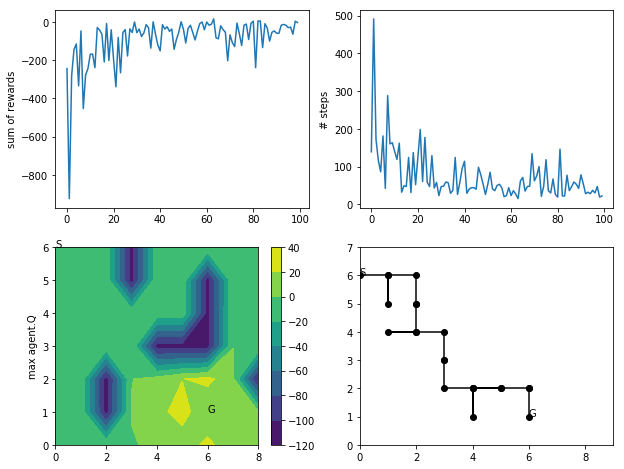

In [34]:
agent = RLAgent(env)
start = [0,0]
rtrace, steps, trace = agent.train(start, 
                                   gamma=0.99, 
                                   alpha=0.1, 
                                   epsilon=0.7, 
                                   maxiter=100, 
                                   maxstep=1000)
plot_train(agent, rtrace, steps, trace, start)

Now, we try ot decrease the value of alpha and increased the value of epsilon. High value of epsilon means random values for actions, rather than based on Q table(because of our epsilon_greedy function). Therefore, the results does not look good. 

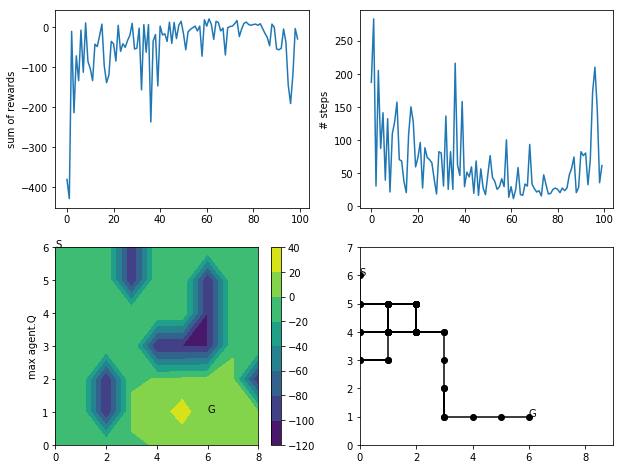

In [35]:
agent = RLAgent(env)
start = [0,0]
rtrace, steps, trace = agent.train(start, 
                                   gamma=0.3, 
                                   alpha=0.1, 
                                   epsilon=0.1, 
                                   maxiter=100, 
                                   maxstep=1000)
plot_train(agent, rtrace, steps, trace, start)

Now, we came to a conclusion on the values of alpha and epsilon, so we try to decrease the value of gamma. This will result in decreasing the weightage for the reward that can be achieved in the next step(based on our updation of Q in SARSA), thus we did not get proper results. Th rewards are having high negative value at the end in our plot which is not a good sign.

In [55]:
agent = RLAgent(env)
start = [0,0]
rtrace, steps, trace = agent.train(start, 
                                   gamma=1.0, 
                                   alpha=0.1, 
                                   epsilon=0.1, 
                                   maxiter=100, 
                                   maxstep=1000)

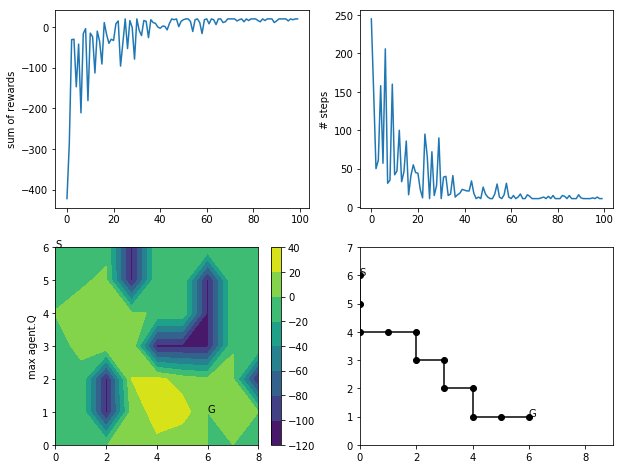

In [56]:
plot_train(agent, rtrace, steps, trace, start)

This combination of parameters look good, as the number of steps near the end of iterations is small and the rewards are also not negative.The optimal path can be obtained with these parameters.

In [28]:
print("Q-table: \n",agent.Q)

Q-table: 
 [[[ -5.16918448  -4.69625229  -5.23035531  -4.51105567]
  [ -4.0104666   -3.97629838  -4.26396229  -3.88921951]
  [ -3.47285972  -3.79088471  -4.22708741  -3.29304961]
  [        -inf         -inf         -inf         -inf]
  [ -1.8993124   -1.52075333  -1.41226541  -1.47264704]
  [ -1.44252046  -1.41675321  -1.3747901   -1.38978655]
  [ -1.18892462  -1.21407082  -1.8991751   -1.91822675]
  [ -0.92172917  -0.9701378   -1.75798328  -0.99592201]
  [ -0.84504532  -0.95        -1.3951582   -0.8756486 ]]

 [[ -4.33927167  -3.88497907  -3.88143565  -3.17714369]
  [ -3.36941194  -3.36730905  -3.55983199  -1.98829029]
  [ -3.01921557  -3.29113424  -3.05079579  -0.79018184]
  [        -inf         -inf         -inf         -inf]
  [ -1.903406    -1.57754892  -1.54578971  -1.50294024]
  [ -1.5059377   -2.35266823  -1.52847673  -1.50389783]
  [        -inf         -inf         -inf         -inf]
  [ -0.95        -0.79218018  -0.87345139  -0.8572112 ]
  [ -0.8061157   -0.95        -0.75

We now try to use our Q table to test with random start points and see if we can reach the goal and also see the reward we can get. 

policy : 
 [[3 3 3 0 3 0 0 3 0]
 [3 1 3 0 3 1 0 1 0]
 [1 1 3 3 1 2 0 2 3]
 [1 1 1 3 0 0 0 3 0]
 [3 0 0 1 3 3 3 3 0]
 [3 0 0 1 1 1 0 0 0]
 [2 2 1 1 2 0 1 0 0]]
reward :  22


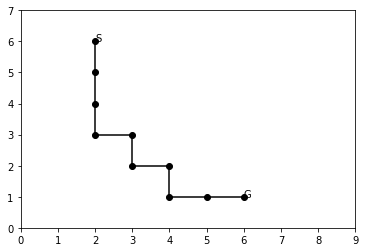

In [57]:
test_start = [0,2]
test_trace, pi, r = agent.test(test_start)
plot_trace(agent, test_start, test_trace)
print("policy : \n", pi)
print("reward : ", r)

policy : 
 [[3 3 3 0 3 0 0 3 0]
 [3 1 3 0 3 1 0 1 0]
 [1 1 3 3 1 2 0 2 3]
 [1 1 1 3 0 0 0 3 0]
 [3 0 0 1 3 3 3 3 0]
 [3 0 0 1 1 1 0 0 0]
 [2 2 1 1 2 0 1 0 0]]
reward :  24


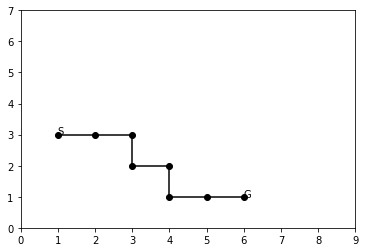

In [61]:
test_start = [3,1]
test_trace, pi, r = agent.test(test_start)
plot_trace(agent, test_start, test_trace)
print("policy : \n", pi)
print("reward : ", r)

We can observe that the Agent is able to find the optimal path from the start to the goal, with maximum rewards. We can say that our RLAgent is perfoming quite well with the model we generated with some good parameters. We are using the same policy for every test data, as the policy is based on the Q table, which we generated using our train data.

policy : 
 [[3 3 3 0 3 0 0 3 0]
 [3 1 3 0 3 1 0 1 0]
 [1 1 3 3 1 2 0 2 3]
 [1 1 1 3 0 0 0 3 0]
 [3 0 0 1 3 3 3 3 0]
 [3 0 0 1 1 1 0 0 0]
 [2 2 1 1 2 0 1 0 0]]
reward :  -1000


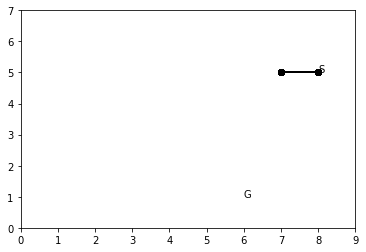

In [62]:
test_start = [1,8]
test_trace,pi,r = agent.test(test_start)
plot_trace(agent, test_start, test_trace)
print("policy : \n", pi)
print("reward : ", r)

We are not finding an optimal path in this case. The agent couldn't trace a path based on our policy. 

### Training and Testing with BlackJack

Lets train our data and plot the rewards over the number of samples. We will give the number of samples as 1000 and number of rounds as 1000, this high numbers will help us in producing maximum number of possible observations, thus our Q table will nbe sufficient for any observation in future tests. We will try different combination of parameters to see which gives us better results.

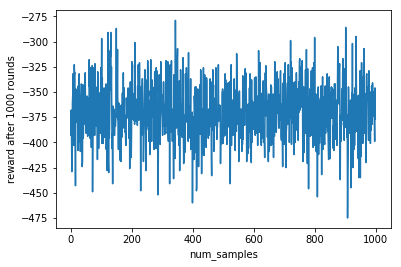

Average reward:  -369.7


In [12]:
env2 = BlackjackEnv()
agent2 = RLAgentB(env=env2, epsilon=0.9, alpha=0.5, gamma=0.5)
avg_reward = agent2.train(1000,1000)
plotBlackJack(avg_reward)
print("Average reward: ",sum(avg_reward)/(1000))

We tested with epsilon as 0.9 and alpha and gamma as 0.5. We got some good results as the average reward is -369.7. But we can get better results. Lets modify these parameters and see.

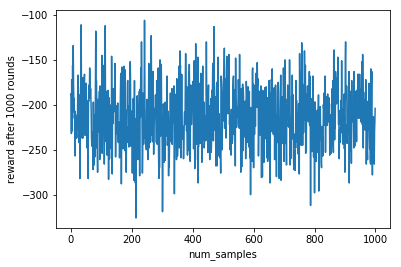

Average reward:  -212.42


In [13]:
env2 = BlackjackEnv()
agent2 = RLAgentB(env=env2, epsilon=0.2, alpha=0.5, gamma=0.5)
avg_reward = agent2.train(1000,1000)
plotBlackJack(avg_reward)
print("Average reward: ",sum(avg_reward)/(1000))

Now we decreased teh value of epsilon value to 0.2. The performance is better compared to the previous result. But we can test with different parameters to see if we can get any better performance.

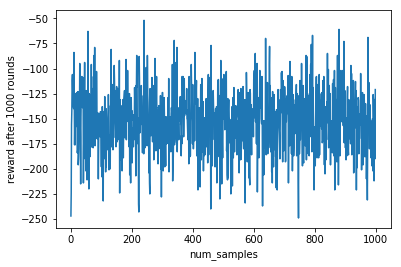

Average reward:  -152.38


In [14]:
env2 = BlackjackEnv()
agent2 = RLAgentB(env=env2, epsilon=0.2, alpha=0.2, gamma=0.2)
avg_reward = agent2.train(1000,1000)
plotBlackJack(avg_reward)
print("Average reward: ",sum(avg_reward)/(1000))

By decreasing the values of alpha and gamma, we got better results. We can say that these parameters can give better performance for our model. Lets the plot the graph a little bigger to get some clarity on how the rewards are varying over the samples. 

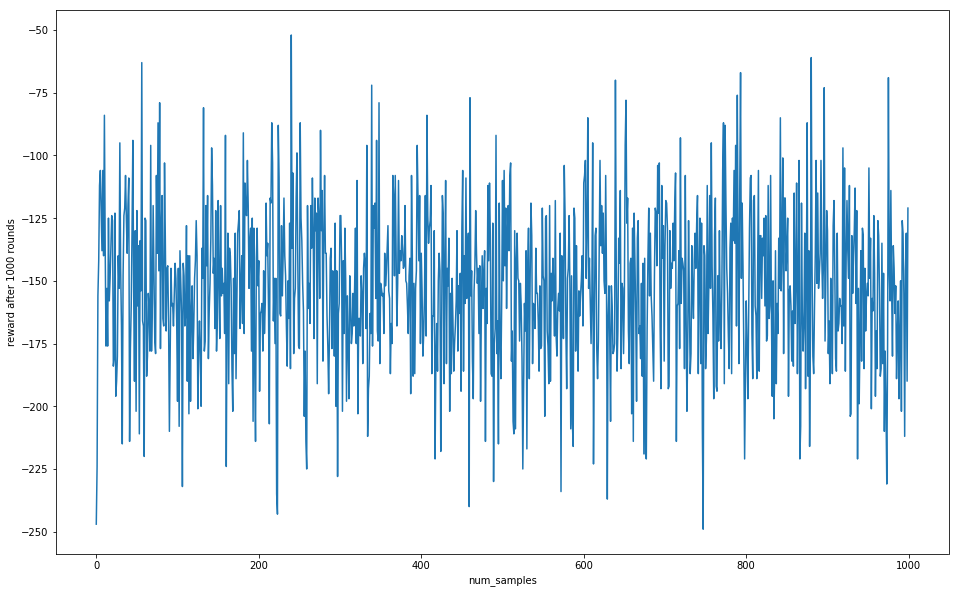

In [15]:
plt.figure(figsize =(16,10))
plotBlackJack(avg_reward)

Now lets test our model with 1000 rounds of play and see the rewards and win percentage. 

In [17]:
rewards, wins = agent2.test2(1000)
print("Total Rewards after 1000 rounds: ", rewards)
print("Win%: ",(wins/1000)*100)
print(agent2.test((15,1,False),1000))
print(agent2.test((12,10,False),1000))
print(agent2.test((12,4,False),1000))
print(agent2.test((2,2,False),1000))

Total Rewards after 1000 rounds:  -113.0
Win%:  39.300000000000004
-1000
-1000
0.0
-473.0


We can observe that the win percentege is pretty good and the loss is not that high. We can say that the model we developed is performing good. We also tested the model by giving random observations, to see how the game proceeds from there. We can observe that the model did perform well is soem cases, but completely failed in other cases. In the 3rd test, the reward is zero, which is better than our win% above. But in the first 2 cases, it is -1000, which is 100% loss. 

# V. Conclusions

We have simulated to problems: Maze and Black jack, and developed to models for those problems based on reinforcement learning techniques: Q learning and SARSA. We trained the models and tested them to see the results. Both the mdoels performed pretty well.

The assignment is very well designed to get hands-on-experiance on reinforcement learing. One of the major challenges I faced during this is to define the state space for the Black jack problem and how to implement the Q table for it. It took some time to understand the concept of black jack. 

# Extra Credit

- Let us have Blackjack-V0 Tournament in class (Mar 22nd.)!
- Top 4 students will get an extra credit. 
- 2 (or more?) unique training attemps will also get an extra credit. (Sales for it to be considered.) 

## Grading

We will test your notebook with an additional grid.txt file. Please make sure to test in different maze input files. 

points | | description
--|--|:--
5 | Overview| states the objective and the appraoch 
10 | Maze Problem | 
 | 5| Includes description of maze problem
 | 5| Explains the GridWorld
10 | Blackjack
 | 5| Includes description of maze problem
 | 5| Explains the Backjack-V0 (OpenAI Gym)
25 | Methods | 
 | 5| Review of the SARSA and Q-Learning
 | 5| Choice of TD learning and Reason
 |10| Implementation of the selected approach
 | 5| explanation of the codes
45 | Results 
| 5| Reports the selected parameters for both problems. 
|20| Experimental outputs that show the choice of parameters. How do you choose them? (10 points per each problem)
|10| Output plots (5 for each)
|10| reading and analysis of learning results and plots (5 for each)
5 | Conclusions 
